In [1]:
import pandas as pd
import numpy as np
import re
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.constraints import MaxNorm
from keras.utils import to_categorical


from imblearn.over_sampling import ADASYN

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight


import keras
print(keras.__version__)

import tensorflow as tf
print(tf.__version__)

import sklearn
import sys
from collections import defaultdict

rs = 10
tf.random.set_seed(rs)
np.random.seed(rs)

print("scikit-learn version:", sklearn.__version__)
print("Python version:", sys.version)

3.10.0
2.19.0
scikit-learn version: 1.6.1
Python version: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]


In [20]:
path_i = r"I:\My Drive\Data_Collected\Offices_processed_ML.csv"

In [21]:
col_study = ['t_sens', 't_satisf', 'daylight', 'dl_satisf', 'sound', 'sound_satisf', 'air_quali', 'o_satisf']
classes = ["Dissatisfied", "Neutral", "Satisfied"]


In [22]:
df = pd.read_csv(path_i)
df = df[col_study]
df

,t_sens,t_satisf,daylight,dl_satisf,sound,sound_satisf,air_quali,o_satisf
0,-2,3,5,1.0,1,0,3,2
1,-2,3,5,0.0,1,0,4,1
2,0,5,3,1.0,3,1,4,2
3,-1,4,5,1.0,1,0,4,2
4,0,4,5,1.0,1,0,3,1
...,...,...,...,...,...,...,...,...
485,-1,3,3,1.0,2,0,5,2
486,-1,3,3,1.0,2,0,5,1
487,-1,5,4,1.0,5,1,5,2
488,0,4,5,1.0,5,1,5,2


In [28]:
y = df['o_satisf'].values 

class_weights_array = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y),y=y)
class_weights = dict(enumerate(class_weights_array))
class_weights = None # Comment this line to run study using the class weights

print("Class weights:", class_weights)

Class weights: None


## NN Model

In [29]:
X = df[['t_sens', 't_satisf', 'dl_satisf', 'sound', 'sound_satisf', 'air_quali']].values
y_raw = df['o_satisf'].values

encoder = LabelEncoder()
y_int = encoder.fit_transform(y_raw)
y_cat = to_categorical(y_int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rs = 0
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=rs)

recall_scores = defaultdict(list)
precision_scores = defaultdict(list)
f1_scores = defaultdict(list)
roc_auc_by_class = defaultdict(list)
precision_macro, f1_macro, precision_0_vs_2, roc_auc_macro = [], [], [], []
accuracy_scores = []

for train_idx, val_idx in cv.split(X_scaled, y_int):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train_int, y_val_int = y_int[train_idx], y_int[val_idx]

    sm = ADASYN(random_state=rs)
    X_train, y_train_int = sm.fit_resample(X_train, y_train_int) # Comment this line to run study on imbalanced data

    y_train = to_categorical(y_train_int)
    y_val = to_categorical(y_val_int)

    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.1))
    model.add(Dense(60, kernel_initializer='normal', activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.1))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    model.compile(SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=400, batch_size=10, verbose=0, validation_data=(X_val, y_val), class_weight=class_weights)

    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true = np.argmax(y_val, axis=1)

    accuracy_scores.append(accuracy_score(y_val_true, y_val_pred_classes))

    for label in np.unique(y_val_true):
        recall_scores[label].append(recall_score(y_val_true, y_val_pred_classes, labels=[label], average='macro'))
        precision_scores[label].append(precision_score(y_val_true, y_val_pred_classes, labels=[label], average='macro'))
        f1_scores[label].append(f1_score(y_val_true, y_val_pred_classes, labels=[label], average='macro'))
        y_bin = (y_val_true == label).astype(int)
        roc_auc_by_class[label].append(roc_auc_score(y_bin, y_val_pred[:, label]))

    precision_macro.append(precision_score(y_val_true, y_val_pred_classes, average='macro'))
    f1_macro.append(f1_score(y_val_true, y_val_pred_classes, average='macro'))
    roc_auc_macro.append(roc_auc_score(y_val_true, y_val_pred, multi_class='ovo', average='macro'))

def mean_ci(metric_list):
    mean = np.mean(metric_list)
    ci = 1.96 * np.std(metric_list, ddof=1) / np.sqrt(len(metric_list))
    return mean, ci

print("\n=== Cross-Validation Metrics for NN Model (with 95% CI) ===")

acc_mean, acc_ci = mean_ci(accuracy_scores)
print(f"CV Score: {acc_mean:.2f} ± {acc_ci:.2f}")

for label in [0, 1, 2]:
    r_mean, r_ci = mean_ci(recall_scores[label])
    print(f"Recall - {label}: {r_mean:.2f} ± {r_ci:.2f}")

pm_mean, pm_ci = mean_ci(precision_macro)
print(f"Precision - Macro: {pm_mean:.2f} ± {pm_ci:.2f}")

for label in [0, 1, 2]:
    p_mean, p_ci = mean_ci(precision_scores[label])
    print(f"Precision - {label}: {p_mean:.2f} ± {p_ci:.2f}")

fm_mean, fm_ci = mean_ci(f1_macro)
print(f"F1 Score - Macro: {fm_mean:.2f} ± {fm_ci:.2f}")

for label in [0, 1, 2]:
    f_mean, f_ci = mean_ci(f1_scores[label])
    print(f"F1 Score - {label}: {f_mean:.2f} ± {f_ci:.2f}")

auc_macro_mean, auc_macro_ci = mean_ci(roc_auc_macro)
print(f"ROC AUC - Macro: {auc_macro_mean:.2f} ± {auc_macro_ci:.2f}")

for label in [0, 1, 2]:
    auc_mean, auc_ci = mean_ci(roc_auc_by_class[label])
    print(f"ROC AUC - {label}: {auc_mean:.2f} ± {auc_ci:.2f}")

c:\Users\jucro\anaconda3\envs\Python_PhD\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


c:\Users\jucro\anaconda3\envs\Python_PhD\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


c:\Users\jucro\anaconda3\envs\Python_PhD\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001FD90020A40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


c:\Users\jucro\anaconda3\envs\Python_PhD\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


c:\Users\jucro\anaconda3\envs\Python_PhD\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


c:\Users\jucro\anaconda3\envs\Python_PhD\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


c:\Users\jucro\anaconda3\envs\Python_PhD\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


c:\Users\jucro\anaconda3\envs\Python_PhD\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


c:\Users\jucro\anaconda3\envs\Python_PhD\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


c:\Users\jucro\anaconda3\envs\Python_PhD\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

=== Cross-Validation Metrics for NN Model (with 95% CI) ===
CV Score: 0.80 ± 0.04
Recall - 0: 0.85 ± 0.21
Recall - 1: 0.81 ± 0.06
Recall - 2: 0.80 ± 0.04
Precision - Macro: 0.66 ± 0.07
Precision - 0: 0.49 ± 0.16
Precision - 1: 0.51 ± 0.08
Precision - 2: 0.98 ± 0.01
F1 Score - Macro: 0.70 ± 0.08
F1 Score - 0: 0.61 ± 0.17
F1 Score - 1: 0.62 ± 0.07
F1 Score - 2: 0.88 ± 0.03
ROC AUC - Macro: 0.89 ± 0.08
ROC AUC - 0: 0.91 ± 0.12
ROC AUC - 1: 0.86 ± 0.03
ROC AUC - 2: 0.92 ± 0.02


In [50]:
rs = 73

X = X = df[['t_sens',  't_satisf', 'dl_satisf', 'sound', 'sound_satisf', 'air_quali']]
y = df['o_satisf']

X = X.values
X = StandardScaler().fit(X).transform(X)
y = y.values

encoder = LabelEncoder()
y1= encoder.fit_transform(y)
y = pd.get_dummies(y1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.70, random_state = rs, stratify= y)

sm = ADASYN(random_state=rs)
X_train, y_train = sm.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.80, random_state = rs)

n_cols = X_train.shape[1]

opt = SGD
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(Dropout(0.1))

model.add(Dense(60, kernel_initializer='normal', activation='relu', kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.1))

model.add(Dense(3, kernel_initializer='normal', activation='softmax'))

model.compile(opt(learning_rate =0.001), loss='categorical_crossentropy', metrics=['accuracy'])

nn_view = model.fit(X_train, y_train, epochs=400, batch_size = 10, class_weight = class_weights, verbose = 0, validation_data=(X_val, y_val))

y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test, axis = 1)
y_pred_class = np.argmax(y_pred, axis = 1)
score = model.evaluate(X_test, y_test)

print(classification_report(y_test_class,y_pred_class))


c:\Users\jucro\anaconda3\envs\Python_PhD\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8519 - loss: 0.3654 
              precision    recall  f1-score   support

           0       0.50      0.83      0.62         6
           1       0.54      0.84      0.66        25
           2       1.00      0.84      0.92       116

    accuracy                           0.84       147
   macro avg       0.68      0.84      0.73       147
weighted avg       0.90      0.84      0.86       147



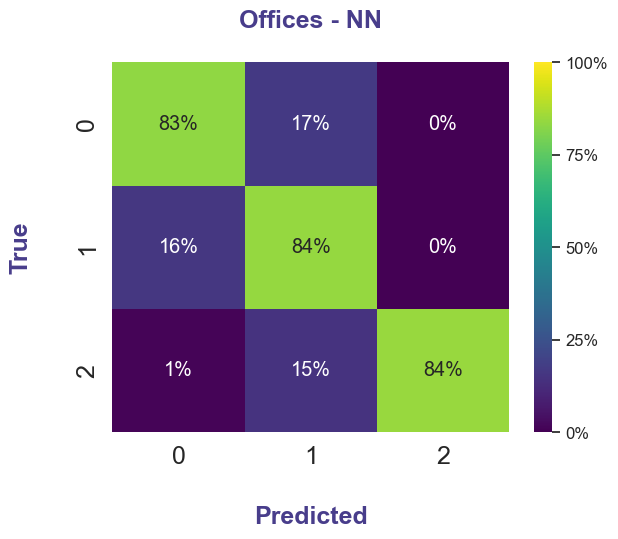

In [ ]:
keras_conf_mx = confusion_matrix(y_test_class,y_pred_class, normalize = 'true')
sns.set_theme()
sns.set(font_scale=1.2)
cmap = "viridis"
ax = sns.heatmap(keras_conf_mx, cmap=cmap, annot=True, cbar=True, vmin=0, vmax=1,fmt='.0%')

plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.xlabel('Predicted', fontdict = {'fontweight': 'bold', 'fontsize': 18}, color = 'darkslateblue')
plt.ylabel('True', fontdict = {'fontweight': 'bold', 'fontsize': 18}, color = 'darkslateblue')
plt.title('Offices - NN\n', fontdict = {'fontweight': 'bold', 'fontsize': 18}, color = 'darkslateblue')

cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, 0.50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'], fontsize = 12)
ax.tick_params(axis='both', which='major', labelsize=18)

ax.xaxis.set_label_coords(.5, -0.2)
ax.yaxis.set_label_coords(-0.2, .5)



In [ ]:
# Save NN model

joblib.dump(nnscaler, r'C:\scaler_home.pkl')
model.save(r'C:\home_nn_model.keras')

## RF Model

In [15]:
rs = 0
X = df[['t_sens', 't_satisf', 'dl_satisf', 'sound', 'sound_satisf', 'air_quali']].values
y = df['o_satisf'].values

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rs)

recall_scores = {label: [] for label in np.unique(y)}
precision_scores = {label: [] for label in np.unique(y)}
f1_scores = {label: [] for label in np.unique(y)}
roc_auc_by_class = {label: [] for label in np.unique(y)}

precision_macro, f1_macro, roc_auc_macro, accuracy_scores = [], [], [], []

for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    sm = ADASYN(random_state=rs)
    #X_train, y_train = sm.fit_resample(X_train, y_train)

    model = RandomForestClassifier(
        class_weight='balanced',
        n_estimators=300,
        n_jobs=-1,
        min_samples_leaf=3,
        min_samples_split=2,
        max_depth=10,
        bootstrap=False,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)

    accuracy_scores.append(accuracy_score(y_val, y_pred))

    for label in np.unique(y):
        recall_scores[label].append(recall_score(y_val, y_pred, labels=[label], average='macro'))
        precision_scores[label].append(precision_score(y_val, y_pred, labels=[label], average='macro'))
        f1_scores[label].append(f1_score(y_val, y_pred, labels=[label], average='macro'))

    precision_macro.append(precision_score(y_val, y_pred, average='macro'))
    f1_macro.append(f1_score(y_val, y_pred, average='macro'))

    roc_auc_macro.append(roc_auc_score(y_val, y_prob, multi_class='ovo', average='macro'))
    for label in np.unique(y):
        y_bin = (y_val == label).astype(int)
        roc_auc_by_class[label].append(roc_auc_score(y_bin, y_prob[:, label]))

def mean_ci(metric_list):
    mean = np.mean(metric_list)
    ci = 1.96 * np.std(metric_list, ddof=1) / np.sqrt(len(metric_list))
    return mean, ci

print("\n=== Cross-Validation Metrics with 95% Confidence Intervals ===")

acc_mean, acc_ci = mean_ci(accuracy_scores)
print(f"CV Score: {acc_mean:.2f} ± {acc_ci:.2f}")

for label in [0, 1, 2]:
    r_mean, r_ci = mean_ci(recall_scores[label])
    print(f"Recall - {label}: {r_mean:.2f} ± {r_ci:.2f}")

pm_mean, pm_ci = mean_ci(precision_macro)
print(f"Precision - Macro: {pm_mean:.2f} ± {pm_ci:.2f}")

for label in [0, 1, 2]:
    p_mean, p_ci = mean_ci(precision_scores[label])
    print(f"Precision - {label}: {p_mean:.2f} ± {p_ci:.2f}")

fm_mean, fm_ci = mean_ci(f1_macro)
print(f"F1 Score - Macro: {fm_mean:.2f} ± {fm_ci:.2f}")

for label in [0, 1, 2]:
    f_mean, f_ci = mean_ci(f1_scores[label])
    print(f"F1 Score - {label}: {f_mean:.2f} ± {f_ci:.2f}")

auc_macro_mean, auc_macro_ci = mean_ci(roc_auc_macro)
print(f"ROC AUC - Macro: {auc_macro_mean:.2f} ± {auc_macro_ci:.2f}")

for label in [0, 1, 2]:
    auc_mean, auc_ci = mean_ci(roc_auc_by_class[label])
    print(f"ROC AUC - {label}: {auc_mean:.2f} ± {auc_ci:.2f}")


=== Cross-Validation Metrics with 95% Confidence Intervals ===
CV Score: 0.82 ± 0.03
Recall - 0: 0.85 ± 0.21
Recall - 1: 0.77 ± 0.07
Recall - 2: 0.83 ± 0.04
Precision - Macro: 0.71 ± 0.08
Precision - 0: 0.63 ± 0.22
Precision - 1: 0.52 ± 0.06
Precision - 2: 0.97 ± 0.02
F1 Score - Macro: 0.74 ± 0.08
F1 Score - 0: 0.70 ± 0.21
F1 Score - 1: 0.61 ± 0.05
F1 Score - 2: 0.89 ± 0.02
ROC AUC - Macro: 0.93 ± 0.05
ROC AUC - 0: 0.98 ± 0.03
ROC AUC - 1: 0.89 ± 0.04
ROC AUC - 2: 0.94 ± 0.02


In [52]:
rs = 73

X = df[['t_sens', 't_satisf', 'dl_satisf', 'sound', 'sound_satisf', 'air_quali']]
y = df['o_satisf']

sm = ADASYN(random_state=rs)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=rs, stratify=y)
#X_train, y_train = sm.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(
    class_weight= 'balanced',
    n_estimators=300,
    n_jobs=-1,
    min_samples_leaf=3,
    min_samples_split=2,
    max_depth=10,
    bootstrap=False,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)

print(classification_report(y_test,y_pred))



              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.52      0.92      0.67        25
           2       0.99      0.81      0.89       116

    accuracy                           0.84       147
   macro avg       0.75      0.91      0.80       147
weighted avg       0.90      0.84      0.85       147



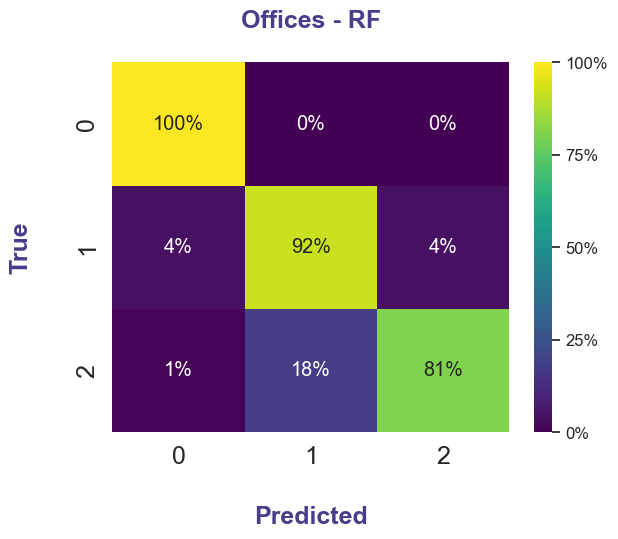

In [ ]:
rf_conf_mx = confusion_matrix(y_test,y_pred, normalize='true')

sns.set_theme()
sns.set(font_scale=1.2)
cmap = "viridis"
ax = sns.heatmap(rf_conf_mx, cmap=cmap, annot=True, cbar=True, vmin=0, vmax=1, fmt='.0%')

plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.xlabel('Predicted', fontdict = {'fontweight': 'bold', 'fontsize': 18}, color = 'darkslateblue')
plt.ylabel('True', fontdict = {'fontweight': 'bold', 'fontsize': 18}, color = 'darkslateblue')
plt.title('Offices - RF\n', fontdict = {'fontweight': 'bold', 'fontsize': 18}, color = 'darkslateblue')

cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, 0.50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'], fontsize = 12)
ax.tick_params(axis='both', which='major', labelsize=18)

ax.xaxis.set_label_coords(.5, -0.2)
ax.yaxis.set_label_coords(-0.2, .5)


In [ ]:
##Save RF model

joblib.dump(rf_model, r'C:\office_rf_model.joblib')